In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("Startup_Scoring_Dataset.csv")

In [3]:
df.head()

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


#### Min Max Normalization

In [6]:
def normalize(series, invert=False):
    norm = (series - series.min()) / (series.max() - series.min())
    return 1 - norm if invert else norm

In [19]:
## Applying normalization on each column

df["team_experience_norm"] = normalize(df["team_experience"])
df["market_size_norm"] = normalize(df["market_size_million_usd"])
df["users_norm"] = normalize(df["monthly_active_users"])
df["burn_norm"] = normalize(df["monthly_burn_rate_inr"], invert=True)
df["funds_norm"] = normalize(df["funds_raised_inr"])
df["valuation_norm"] = normalize(df["valuation_inr"])

#### Assigning Weights

In [9]:
weights = {
    "team_experience_norm": 0.15,
    "market_size_norm": 0.20,
    "users_norm": 0.25,
    "burn_norm": 0.10,
    "funds_norm": 0.15,
    "valuation_norm": 0.15
}

Weight Choice Justification:
- Team Experience (15%): Reflects founder maturity
- Market Size (20%): Large Market Size = big opportunity
- Users (25%): Strong signal of traction
- Burn Rate (10%): Lower is better; inverted during normalization
- Funds Raised (15%) and Valuation (15%): Represent investor confidence


In [10]:
df["final_score"] = sum(df[col] * w for col, w in weights.items()) * 100


#### Ranking


In [11]:
df_sorted = df.sort_values("final_score", ascending=False).reset_index(drop=True)

top_10 = df_sorted.head(10)
bottom_10 = df_sorted.tail(10)

#### Visualization


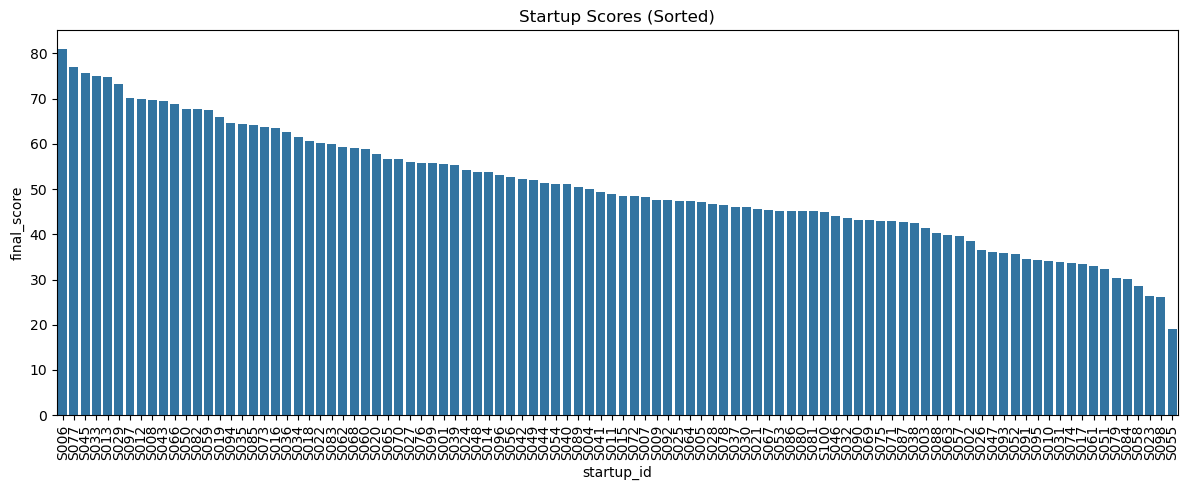

In [20]:
## Bar plot of Startup Scores

plt.figure(figsize=(12, 5))
sns.barplot(x="startup_id", y="final_score", data=df_sorted)
plt.xticks(rotation=90)
plt.title("Startup Scores (Sorted)")
plt.tight_layout()
plt.savefig("Outputs/sorted_scores.png")
plt.show()

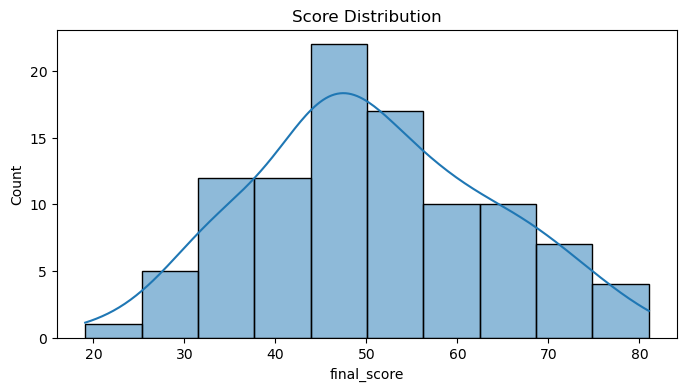

In [21]:
## Histogram showing distribution of scores

plt.figure(figsize=(8, 4))
sns.histplot(df["final_score"], bins=10, kde=True)
plt.title("Score Distribution")
plt.savefig("Outputs/score_histogram.png")
plt.show()

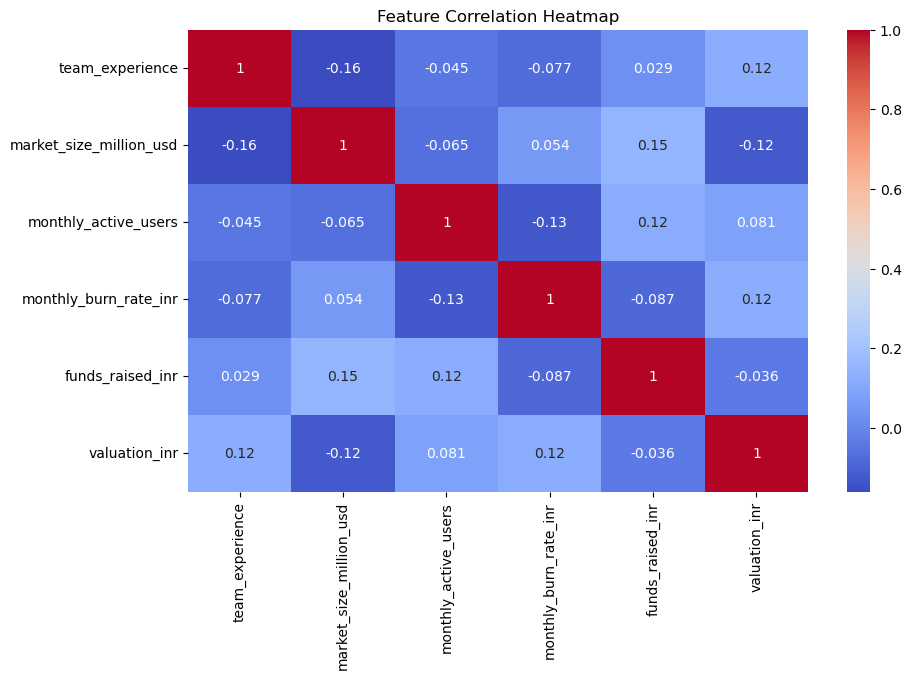

In [16]:
## Heatmap to show relation between columns/attributes 

plt.figure(figsize=(10, 6))
sns.heatmap(df[[
    "team_experience", "market_size_million_usd", "monthly_active_users",
    "monthly_burn_rate_inr", "funds_raised_inr", "valuation_inr"
]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.savefig("Outputs/correlation_heatmap.png")
plt.show()

Observations:
- Some startups have high valuation but low users or high burn — these scored poorly.
- High scorers had balanced strength across users, funding, and market.

#### Documentation

In [17]:
df_sorted.to_csv("Outputs/scored_startups.csv", index=False)
top_10.to_csv("Outputs/top_10_startups.csv", index=False)
bottom_10.to_csv("Outputs/bottom_10_startups.csv", index=False)

#### Using Linear Regression

In [22]:
features = [
    "team_experience", "market_size_million_usd", "monthly_active_users",
    "monthly_burn_rate_inr", "funds_raised_inr"
]
X = df[features]
y = df["valuation_inr"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
print("\n--- ML Model Output ---")
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


--- ML Model Output ---
R2 Score: -0.09521992132419155
RMSE: 167744227.4413443


C:\Users\vedan\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
coefficients = pd.Series(model.coef_, index=features)
print("\nFeature Coefficients:\n", coefficients)


Feature Coefficients:
 team_experience            5.439426e+06
market_size_million_usd   -9.504908e+04
monthly_active_users       7.346556e+01
monthly_burn_rate_inr      6.562103e+00
funds_raised_inr          -1.988199e-01
dtype: float64



- I added a simple Linear Regression model to predict valuation.
- This gave me a quick way to see which features matter most.
- The R² score and coefficients helped me double-check if my logic made sense.